Project Setup and Dependencies:

This section imports the necessary libraries, defines the material properties, and sets up the computational environment.

In [ ]:
#Setup and Dependencies

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Set TensorFlow to float64 for better numerical stability in PINNs
tf.keras.backend.set_floatx('float64')

#Material and Domain Parameters

# Young's Modulus (E)
E = 1.0 
# Poisson's Ratio (nu)
nu = 0.3 

# Lame parameters (for simplification in constitutive relations)
# C1 = E / (1 - nu**2)
C1 = E / (1.0 - nu**2)
# C2 = E * nu / (1 - nu**2)
C2 = E * nu / (1.0 - nu**2)
# G = E / (2 * (1 + nu)) (Shear modulus)
G = E / (2.0 * (1.0 + nu))

# Domain
DOMAIN_X = [0.0, 1.0]
DOMAIN_Y = [0.0, 1.0]

# Body Forces (f_x, f_y)
f_x = 0.0
f_y = -1.0 # Uniform load in -y direction

Neural Network Model Definition:


A standard Multi-Layer Perceptron (MLP) is used as the backbone of the PINN to approximate the displacement fields u(x,y) and v(x,y).

In [5]:
#Neural Network Model

def create_pinn_model(input_shape, output_shape, num_layers, num_neurons):
    """Creates a simple fully-connected neural network (MLP)."""
    model = Sequential()
    model.add(Dense(num_neurons, activation='tanh', input_shape=(input_shape,)))
    for _ in range(num_layers - 1):
        model.add(Dense(num_neurons, activation='tanh'))
    # Two outputs: u and v displacements
    model.add(Dense(output_shape, activation=None)) 
    return model

# Model parameters
input_dim = 2  # (x, y)
output_dim = 2 # (u, v)
num_layers = 4
num_neurons = 50

# Instantiate the model
model = create_pinn_model(input_dim, output_dim, num_layers, num_neurons)
model.summary()

c:\Users\manch\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 50)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,902 (61.73 KB)

 Trainable params: 7,902 (61.73 KB)

 Non-trainable params: 0 (0.00 B)

Governing Equations and Loss Function (The PINN Core)
This is the most critical part, where automatic differentiation is used to compute the derivatives (strains, stresses, and PDE residuals) necessary for the physics-based loss function.

A. Automatic Differentiation and Physics Calculation

In [6]:
#Physics Loss Function Implementation

def compute_physics_loss(model, X_collocation):
    """
    Computes the loss from the PDE residuals and boundary conditions.
    
    X_collocation: a tensor of (x, y) points inside the domain.
    """
    
    # 1. Automatic Differentiation Setup
    x = X_collocation[:, 0:1] # x coordinates
    y = X_collocation[:, 1:2] # y coordinates
    
    # Enable gradient tracking for the coordinates
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        tape.watch(y)
        
        # Concatenate x and y for the model input
        X_in = tf.stack([tf.squeeze(x), tf.squeeze(y)], axis=1)
        
        # Predict displacements (u, v)
        u_v = model(X_in)
        u = u_v[:, 0:1]
        v = u_v[:, 1:2]

        # Calculate first derivatives of u and v
        u_x = tape.gradient(u, x)
        u_y = tape.gradient(u, y)
        v_x = tape.gradient(v, x)
        v_y = tape.gradient(v, y)

        # 2. Strain-Displacement Relations
        epsilon_xx = u_x
        epsilon_yy = v_y
        epsilon_xy = 0.5 * (u_y + v_x) # Engineering shear strain is 2 * epsilon_xy

        # 3. Hooke's Law (Plane Stress)
        # Note: Shear stress is calculated using G * 2 * epsilon_xy, which is G * (u_y + v_x)
        sigma_xx = C1 * epsilon_xx + C2 * epsilon_yy
        sigma_yy = C1 * epsilon_yy + C2 * epsilon_xx
        sigma_xy = G * (u_y + v_x) # E/(2*(1+nu)) * (u_y + v_x)

    # 4. Calculate Second Derivatives for Equilibrium Equations
    sigma_xx_x = tape.gradient(sigma_xx, x)
    sigma_xy_y = tape.gradient(sigma_xy, y)
    sigma_yy_y = tape.gradient(sigma_yy, y)
    sigma_xy_x = tape.gradient(sigma_xy, x)

    del tape # Cleanup the tape

    # 5. Equilibrium Equations (PDE Residuals)
    # R_x = d(sigma_xx)/dx + d(sigma_xy)/dy + f_x
    R_x = sigma_xx_x + sigma_xy_y + f_x
    # R_y = d(sigma_yy)/dy + d(sigma_xy)/dx + f_y
    R_y = sigma_yy_y + sigma_xy_x + f_y

    # Calculate PDE Loss (Mean Squared Error of the residuals)
    loss_pde = tf.reduce_mean(tf.square(R_x)) + tf.reduce_mean(tf.square(R_y))
    
    return loss_pde, R_x, R_y

B. Full Loss Function (PDE + BCs) and Training Step

In [ ]:
#Combined Loss and Training Step

def compute_bc_loss(model, X_bc, bc_type='left_fixed'):
    """
    Computes the loss from the boundary conditions.
    X_bc: Coordinates on the boundary.
    """
    
    x = X_bc[:, 0:1] 
    y = X_bc[:, 1:2] 
    
    X_in = tf.stack([tf.squeeze(x), tf.squeeze(y)], axis=1)
    u_v = model(X_in)
    u = u_v[:, 0:1]
    v = u_v[:, 1:2]
    
    loss_bc = 0.0
    
    if bc_type == 'left_fixed':
        # Left edge (x=0): Dirichlet BC (u=0, v=0)
        u_target = tf.zeros_like(u)
        v_target = tf.zeros_like(v)
        loss_bc = tf.reduce_mean(tf.square(u - u_target)) + tf.reduce_mean(tf.square(v - v_target))
        
    elif bc_type in ['right_traction_free', 'top_traction_free', 'bottom_traction_free']:
        # Traction-Free BCs (Neumann)
        # We need derivatives to compute stress, so we set up a tape
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(x)
            tape.watch(y)
            
            X_in_bc = tf.stack([tf.squeeze(x), tf.squeeze(y)], axis=1)
            u_v_bc = model(X_in_bc)
            u_bc = u_v_bc[:, 0:1]
            v_bc = u_v_bc[:, 1:2]
            
            u_x = tape.gradient(u_bc, x)
            u_y = tape.gradient(u_bc, y)
            v_x = tape.gradient(v_bc, x)
            v_y = tape.gradient(v_bc, y)
            
            # Strains
            epsilon_xx = u_x
            epsilon_yy = v_y
            # Stresses
            sigma_xx = C1 * epsilon_xx + C2 * epsilon_yy
            sigma_yy = C1 * epsilon_yy + C2 * epsilon_xx
            sigma_xy = G * (u_y + v_x)
        del tape
        
        # Right edge (x=1): sigma_xx = 0, sigma_xy = 0
        if bc_type == 'right_traction_free':
            loss_bc = tf.reduce_mean(tf.square(sigma_xx)) + tf.reduce_mean(tf.square(sigma_xy))
        
        # Top/Bottom edges (y=1/y=0): sigma_yy = 0, sigma_xy = 0
        elif bc_type in ['top_traction_free', 'bottom_traction_free']:
            loss_bc = tf.reduce_mean(tf.square(sigma_yy)) + tf.reduce_mean(tf.square(sigma_xy))

    return loss_bc


#Optimizer and Training Step Definition

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

@tf.function
def train_step(X_collocation, X_bc_list, weights=[1.0, 1.0, 1.0, 1.0, 1.0]):
    """Performs a single training step."""
    
    with tf.GradientTape() as tape:
        # 1. PDE Loss
        loss_pde, _, _ = compute_physics_loss(model, X_collocation)
        
        # 2. BC Losses
        loss_bc_left = compute_bc_loss(model, X_bc_list[0], 'left_fixed')
        loss_bc_right = compute_bc_loss(model, X_bc_list[1], 'right_traction_free')
        loss_bc_top = compute_bc_loss(model, X_bc_list[2], 'top_traction_free')
        loss_bc_bottom = compute_bc_loss(model, X_bc_list[3], 'bottom_traction_free')
        
        # 3. Total Loss (Weighted Sum)
        total_loss = (weights[0] * loss_pde + 
                      weights[1] * loss_bc_left +
                      weights[2] * loss_bc_right +
                      weights[3] * loss_bc_top +
                      weights[4] * loss_bc_bottom)

    # 4. Gradient Descent
    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return total_loss, loss_pde, loss_bc_left, loss_bc_right, loss_bc_top, loss_bc_bottom

Data Generation (Collocation and Boundary Points)

PINNs do not require labeled data; they only require sample points in the domain and on the boundary.

In [8]:
#Data Point Generation

N_collocation = 10000 # Number of interior points
N_bc = 200 # Number of points per boundary edge

# 1. Interior Collocation Points (PDE points)
X_collocation = tf.random.uniform(shape=(N_collocation, 2), 
                                  minval=[DOMAIN_X[0], DOMAIN_Y[0]], 
                                  maxval=[DOMAIN_X[1], DOMAIN_Y[1]], 
                                  dtype=tf.float64)

# 2. Boundary Condition Points (BC points)
# Left edge (x=0): fixed (u=0, v=0)
X_bc_left = tf.stack([tf.zeros(N_bc, dtype=tf.float64), 
                      tf.random.uniform(shape=(N_bc,), minval=DOMAIN_Y[0], maxval=DOMAIN_Y[1], dtype=tf.float64)], axis=1)

# Right edge (x=1): traction-free (sigma_xx=0, sigma_xy=0)
X_bc_right = tf.stack([tf.ones(N_bc, dtype=tf.float64), 
                       tf.random.uniform(shape=(N_bc,), minval=DOMAIN_Y[0], maxval=DOMAIN_Y[1], dtype=tf.float64)], axis=1)

# Top edge (y=1): traction-free (sigma_yy=0, sigma_xy=0)
X_bc_top = tf.stack([tf.random.uniform(shape=(N_bc,), minval=DOMAIN_X[0], maxval=DOMAIN_X[1], dtype=tf.float64), 
                     tf.ones(N_bc, dtype=tf.float64)], axis=1)

# Bottom edge (y=0): traction-free (sigma_yy=0, sigma_xy=0)
X_bc_bottom = tf.stack([tf.random.uniform(shape=(N_bc,), minval=DOMAIN_X[0], maxval=DOMAIN_X[1], dtype=tf.float64), 
                        tf.zeros(N_bc, dtype=tf.float64)], axis=1)

# List of BC points for training step
X_bc_list = [X_bc_left, X_bc_right, X_bc_top, X_bc_bottom]

print(f"Collocation points shape: {X_collocation.shape}")
print(f"BC points per edge shape: {X_bc_left.shape}")

Collocation points shape: (10000, 2)
BC points per edge shape: (200, 2)


Model Training

Starting training...
Epoch 1/10000:
  Total Loss: 1.151376e-02
  (PDE: 1.347753e-03, BC_L: 6.198347e-03, BC_R: 2.172063e-03, BC_T: 7.987554e-04, BC_B: 9.968384e-04)
Epoch 1000/10000:
  Total Loss: 8.716308e-03
  (PDE: 1.667267e-03, BC_L: 3.386905e-03, BC_R: 1.895782e-03, BC_T: 9.354342e-04, BC_B: 8.309198e-04)
Epoch 2000/10000:
  Total Loss: 6.031356e-03
  (PDE: 1.263760e-03, BC_L: 2.086781e-03, BC_R: 1.682517e-03, BC_T: 4.500107e-04, BC_B: 5.482885e-04)
Epoch 3000/10000:
  Total Loss: 4.689025e-03
  (PDE: 6.349697e-04, BC_L: 1.623363e-03, BC_R: 1.609980e-03, BC_T: 4.283113e-04, BC_B: 3.924009e-04)
Epoch 4000/10000:
  Total Loss: 4.323765e-03
  (PDE: 5.509409e-04, BC_L: 1.502013e-03, BC_R: 1.517530e-03, BC_T: 3.960870e-04, BC_B: 3.571944e-04)
Epoch 5000/10000:
  Total Loss: 3.976014e-03
  (PDE: 5.491671e-04, BC_L: 1.443272e-03, BC_R: 1.393558e-03, BC_T: 3.142174e-04, BC_B: 2.757997e-04)
Epoch 6000/10000:
  Total Loss: 3.685696e-03
  (PDE: 5.277677e-04, BC_L: 1.386414e-03, BC_R: 1.24227

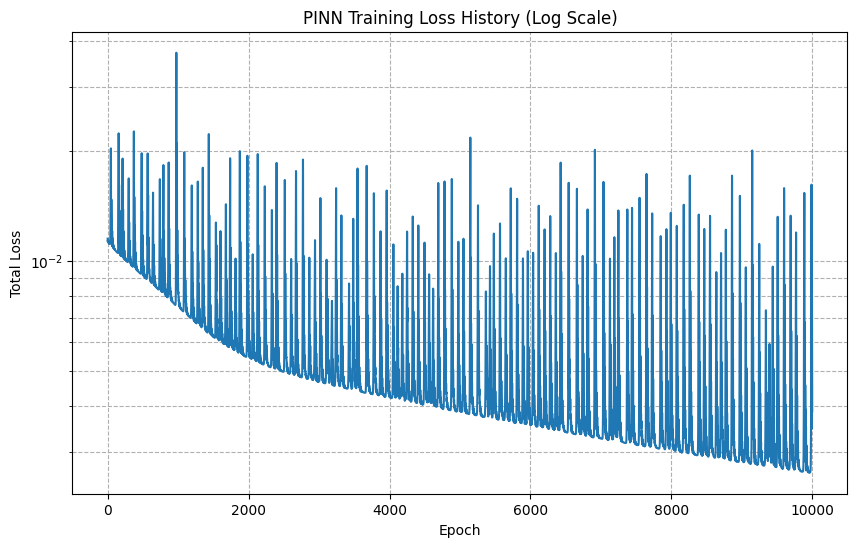

In [11]:
#Training Loop

epochs = 10000 
loss_history = []
print_interval = 1000

print("Starting training...")

for epoch in range(1, epochs + 1):
    # Adjusting weights can be a sophisticated strategy (e.g., adaptive weighting)
    # but for simplicity, we use fixed weights here.
    weights = [1.0, 1.0, 1.0, 1.0, 1.0] # [PDE, BC_L, BC_R, BC_T, BC_B]
    
    total_loss, loss_pde, loss_bc_l, loss_bc_r, loss_bc_t, loss_bc_b = train_step(
        X_collocation, X_bc_list, weights
    )
    
    loss_history.append(total_loss.numpy())
    
    if epoch % print_interval == 0 or epoch == 1:
        print(f"Epoch {epoch}/{epochs}:")
        print(f"  Total Loss: {total_loss.numpy():.6e}")
        print(f"  (PDE: {loss_pde.numpy():.6e}, BC_L: {loss_bc_l.numpy():.6e}, BC_R: {loss_bc_r.numpy():.6e}, BC_T: {loss_bc_t.numpy():.6e}, BC_B: {loss_bc_b.numpy():.6e})")

print("Training finished.")

# Plot Loss History
plt.figure(figsize=(10, 6))
plt.plot(loss_history)
plt.yscale('log')
plt.title('PINN Training Loss History (Log Scale)')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.grid(True, which="both", ls="--")
plt.show()

Prediction and Visualization

This section creates a dense grid of points, uses the trained model to predict the displacements, and then calculates the derived quantities (strains, stresses) for visualization.

<>:88: SyntaxWarning: invalid escape sequence '\s'
<>:91: SyntaxWarning: invalid escape sequence '\s'
<>:94: SyntaxWarning: invalid escape sequence '\s'
<>:88: SyntaxWarning: invalid escape sequence '\s'
<>:91: SyntaxWarning: invalid escape sequence '\s'
<>:94: SyntaxWarning: invalid escape sequence '\s'
C:\Users\manch\AppData\Local\Temp\ipykernel_3880\3491355542.py:88: SyntaxWarning: invalid escape sequence '\s'
  plot_field(X, Y, results['sig_xx'], 'Stress $\sigma_{xx}$', axes[3])
C:\Users\manch\AppData\Local\Temp\ipykernel_3880\3491355542.py:91: SyntaxWarning: invalid escape sequence '\s'
  plot_field(X, Y, results['sig_yy'], 'Stress $\sigma_{yy}$', axes[4])
C:\Users\manch\AppData\Local\Temp\ipykernel_3880\3491355542.py:94: SyntaxWarning: invalid escape sequence '\s'
  plot_field(X, Y, results['sig_xy'], 'Stress $\sigma_{xy}$', axes[5])


C:\Users\manch\AppData\Local\Temp\ipykernel_3880\3491355542.py:88: SyntaxWarning: invalid escape sequence '\s'
  plot_field(X, Y, results['sig_xx'], 'Stress $\sigma_{xx}$', axes[3])
C:\Users\manch\AppData\Local\Temp\ipykernel_3880\3491355542.py:91: SyntaxWarning: invalid escape sequence '\s'
  plot_field(X, Y, results['sig_yy'], 'Stress $\sigma_{yy}$', axes[4])
C:\Users\manch\AppData\Local\Temp\ipykernel_3880\3491355542.py:94: SyntaxWarning: invalid escape sequence '\s'
  plot_field(X, Y, results['sig_xy'], 'Stress $\sigma_{xy}$', axes[5])


AttributeError: module 'matplotlib.pylab' has no attribute 'make_axes_locatable'

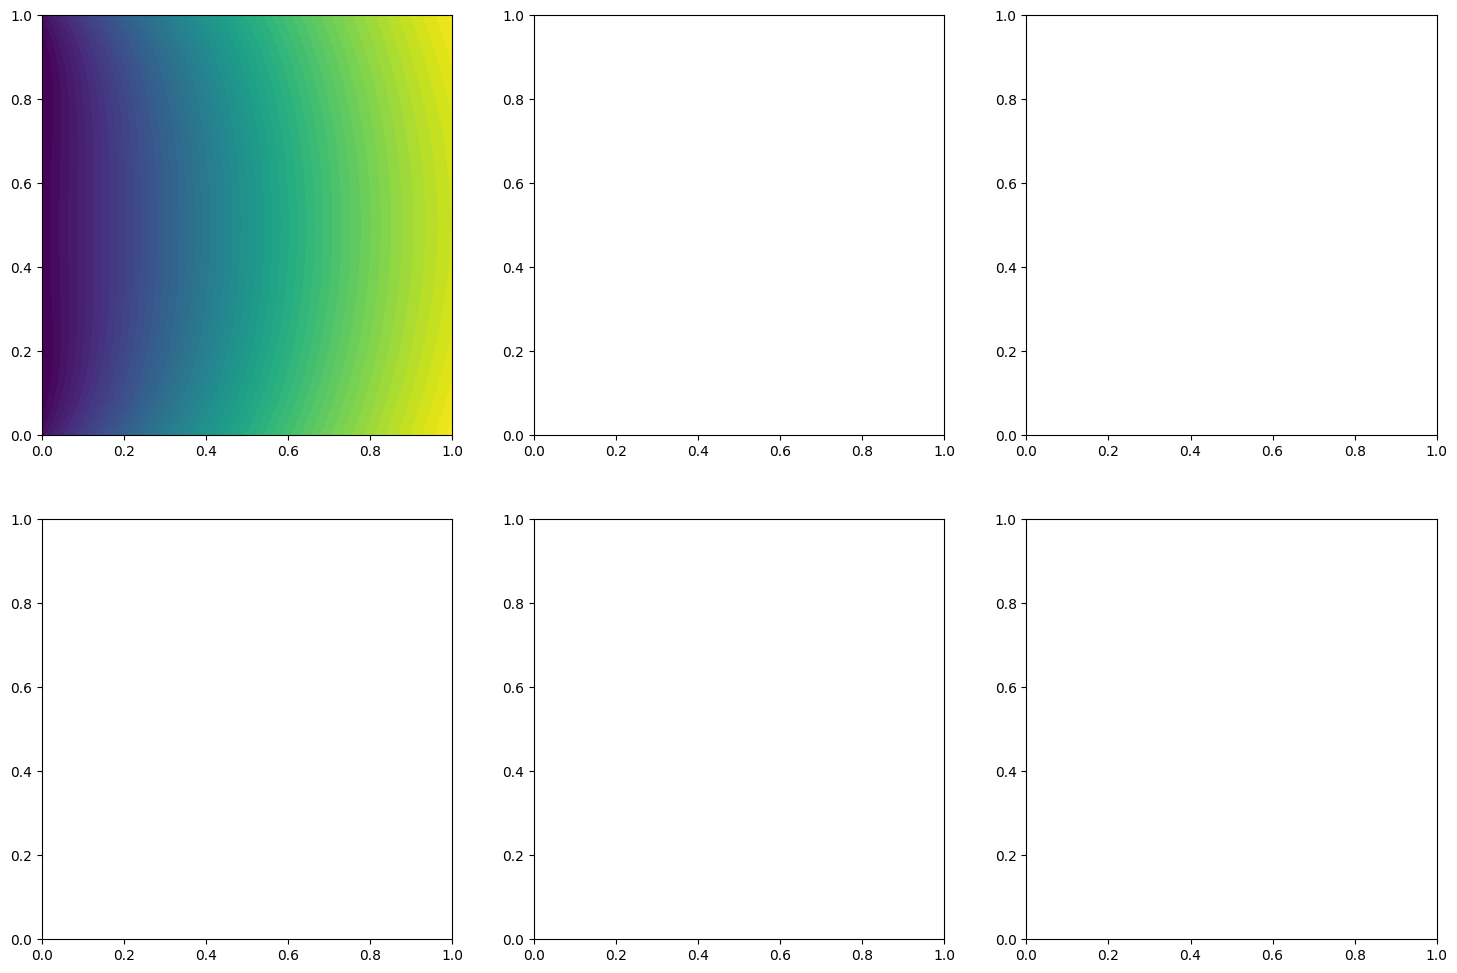

In [12]:
#Prediction and Visualization

# Utility function to calculate all fields
def calculate_fields(model, X_grid):
    """Calculates u, v, strains, and stresses over a given grid."""
    
    x = tf.constant(X_grid[:, 0:1], dtype=tf.float64)
    y = tf.constant(X_grid[:, 1:2], dtype=tf.float64)

    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        tape.watch(y)
        
        X_in = tf.stack([tf.squeeze(x), tf.squeeze(y)], axis=1)
        u_v = model(X_in)
        u = u_v[:, 0:1]
        v = u_v[:, 1:2]

        u_x = tape.gradient(u, x)
        u_y = tape.gradient(u, y)
        v_x = tape.gradient(v, x)
        v_y = tape.gradient(v, y)

        # Strains
        eps_xx = u_x
        eps_yy = v_y
        eps_xy = 0.5 * (u_y + v_x)

        # Stresses (Plane Stress)
        sig_xx = C1 * eps_xx + C2 * eps_yy
        sig_yy = C1 * eps_yy + C2 * eps_xx
        sig_xy = G * (u_y + v_x)
        
    del tape
    
    # Detach tensors from the computational graph and convert to numpy
    U_mag = np.sqrt(u.numpy()**2 + v.numpy()**2)
    
    return {
        'u': u.numpy().flatten(), 'v': v.numpy().flatten(), 'U_mag': U_mag.flatten(),
        'sig_xx': sig_xx.numpy().flatten(), 'sig_yy': sig_yy.numpy().flatten(), 'sig_xy': sig_xy.numpy().flatten(),
        'eps_xx': eps_xx.numpy().flatten(), 'eps_yy': eps_yy.numpy().flatten(), 'eps_xy': eps_xy.numpy().flatten()
    }

#Create evaluation grid
nx, ny = 100, 100
x_flat = np.linspace(DOMAIN_X[0], DOMAIN_X[1], nx)
y_flat = np.linspace(DOMAIN_Y[0], DOMAIN_Y[1], ny)
X, Y = np.meshgrid(x_flat, y_flat)
X_grid = np.hstack((X.flatten()[:, None], Y.flatten()[:, None]))

#Calculate all results
results = calculate_fields(model, X_grid)

# --- Plotting function ---
def plot_field(X, Y, Z, title, ax):
    """Contour plot utility."""
    Z_reshaped = Z.reshape(X.shape)
    
    h = ax.contourf(X, Y, Z_reshaped, 50, cmap=cm.viridis)
    
    divider = make_axes_grid1.make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(h, cax=cax, format='%.2e')
    
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_aspect('equal', adjustable='box')


# Generate Plots
import matplotlib.pylab as make_axes_grid1

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# 1. Displacement Magnitude
plot_field(X, Y, results['U_mag'], 'Displacement Magnitude ($|U|$)', axes[0])

# 2. u-Displacement
plot_field(X, Y, results['u'], '$u$-Displacement', axes[1])

# 3. v-Displacement
plot_field(X, Y, results['v'], '$v$-Displacement', axes[2])

# 4. $\sigma_{xx}$ Stress
plot_field(X, Y, results['sig_xx'], 'Stress $\sigma_{xx}$', axes[3])

# 5. $\sigma_{yy}$ Stress
plot_field(X, Y, results['sig_yy'], 'Stress $\sigma_{yy}$', axes[4])

# 6. $\sigma_{xy}$ Stress
plot_field(X, Y, results['sig_xy'], 'Stress $\sigma_{xy}$', axes[5])

plt.tight_layout()
plt.show()

print("\n--- Project Summary ---")
print("Implemented a Physics-Informed Neural Network (PINN) to solve the 2D elasticity equations, predicting displacement and stress fields in a loaded square plate under plane stress conditions.")